## 2570 Proj 3
___Warren Shi___

In [1]:
## Set up 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

%matplotlib inline

### Q1 

### a). simulation function

In [2]:
## i) function for simulation
'''
Function sim_exp
This function takes the intensity parameter alpha and number of simulations n to simulate n iid wait times 
(exponential distribution) for a Poisson Process with intensity alpha. 

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times (exponential variable)
'''
def sim_exp(n = 1, alpha = 3):
    result = -np.log(1 - np.random.uniform(0,1,n)) / alpha
    if n == 1:
        return result[0]
    else: 
        return result

In [3]:
## ii) find N
# we find the variance first from the pilot study
pilot_size = 150
pilot_data = sim_exp(pilot_size)
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))

In [4]:
## iii) find CI
wt_sample = sim_exp(target_N)
e_wt = np.mean(wt_sample)
se_wt = np.sqrt(np.var(wt_sample)/target_N)
CI_lower, CI_upper = e_wt - z * se_wt, e_wt + z * se_wt

In [5]:
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Wt is   : ' + str(e_wt)) 
print('The 99% confidence interval is        : ' + str((CI_lower, CI_upper))) 

The required sample size for the CI is: 6498
The estimated expect value of Wt is   : 0.3280569750717049
The 99% confidence interval is        : (0.31749322398269697, 0.3386207261607128)


### b). acceptance-rejection

In [6]:
def pdf_1b(x, alpha = 3, t = 1):
    if np.isscalar(x):
        x = np.array(x)
    arr1 = np.where((x<=t) & (x>0), alpha**2 * x * np.exp(-alpha*x), 0)
    arr2 = np.where(x>t, alpha * (1 + alpha * t) * np.exp(-alpha*x), 0)
    return arr1 + arr2

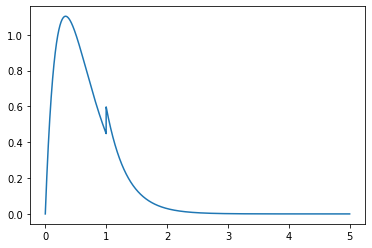

In [7]:
x = np.linspace(0,5,10000)
plt.plot(x, pdf_1b(x));

In [8]:
import scipy.integrate as integrate
integrate.quad(pdf_1b, 0, 10)

(0.9999999999991455, 1.0003499140154304e-09)

In [9]:
pdf_1b(5)

3.6708278460219094e-06

In [33]:
def sim_1b():
    ## coin toss
    ##if np.random.uniform() < 1-16/(3*np.exp(-1)-12*np.exp(-4)+16):
    if np.random.uniform() < 1/400:
        ## first half
        c = pdf_1b(1/3)
        unif1 = np.random.uniform()
        if np.random.uniform() <= pdf_1b(unif1)/c:
            return unif1
        else:
            return sim_1b()
    else:
        ## second half
        c = 4
        expn = sim_exp()
        if expn > st.expon.pdf(1, 0, 1/3) and np.random.uniform() <= pdf_1b(expn)/(c*st.expon.pdf(expn, 0, 1/3)):
            return expn
        else:
            return sim_1b()

In [34]:
trythis = [sim_1b() for i in range(100000)]

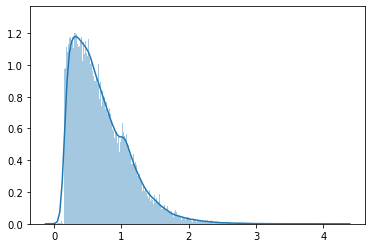

In [35]:
sns.distplot(trythis, bins = 1000)

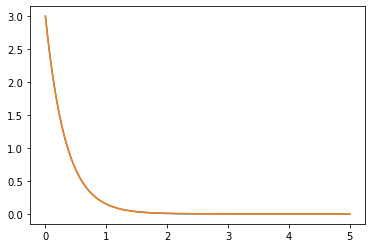

In [36]:
x = np.linspace(0,5,1000)
plt.plot(x, st.expon.pdf(x, 0, 1/3))
plt.plot(x, 3*np.exp(-3*x))

In [30]:
3*np.exp(-1)-12*np.exp(-4)

0.8838506568495168